## Import Libraries

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
import warnings
import import_ipynb
from Utility import *
from Collaborative_filtering import *

warnings.simplefilter(action='ignore', category=FutureWarning)
import random

warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

 ### Read Music Data by artists

In [39]:
data = pd.read_csv(r"datasets/data_by_artist.csv")
data.head()

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5


We only need **'valence', 'artists', 'count', 'popularity'** fields from the dataset. Hence, retrieving those fields and saving it in a csv file named as "artist_data.csv"


In [40]:
artist_data = data[['valence', 'artists', 'count', 'popularity']]
artist_data.to_csv('datasets/artist_data.csv')

## Hybrid Song Recommendation 

It is a recommendation system which is combination of the content and collaborative filtering method.  By using content and collaborative-based methods to generate predictions separately and then combining the prediction, we can generate more accurate recommendations and also reduces the problem of cold start.

1. **Collaborative filtering**: 

2. **Content based filtering**:

    a. **PCA_algorithm**: to reduce the dimensionality (in our case number of components is 2) within a dataset while still retaining as much information as possible.

     b.**KMeans_with_PCA_algorithm**: algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping clusters. 
    Based on the values of the Within Cluster Sum of Squares (WCSS) and an approach known as the Elbow method, we made a decision about how many clusters we’d like to keep.In our case, we have kept number of cluster as 50.

     c.we have then created a new data frame df_segm_pca_kmeans. It allows us to add in the values of the separate components to our segmentation data set. The components’ scores are stored in the ‘scores P C A’ variable. Let’s label them com1 and com2.

     d.**filter_based_on_segment**: filters songs that belong to particulat cluster segment.

     e.**filter_based_on_cluster_centroid**: filters songs based on closet distance of song and centroid

3. returns list of top n artists with songs, where n is set as 10 in our case

In [41]:
def recommend_artists(artist,  n=10):    
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    song_embedding = PCA_algorithm(artist_data)
    kmeans_pca, centroids = KMeans_with_PCA_algorithm(song_embedding,50)

    df_segm_pca_kmeans = pd.concat([artist_data.reset_index(drop=True), pd.DataFrame(song_embedding)], axis=1)
    df_segm_pca_kmeans.columns.values[-2:] = ['com1', 'com2']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    #get segment value of artist
    segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['artists'] == artist]['Segment K-means PCA'].values[0]

    filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans, segment_val,'artists', 'valence')

    rec_artists = filter_based_on_cluster_centroid(kmeans_pca, filtered_data_per_segment, segment_val, artist_data)

    #recommend top n artists
    return rec_artists.head(n)['artists'].tolist()

**recommend_artist_and_songs:** Finds list of songs and artists  based on the selected artist name 
Recommends Top N artist with their song(s). In  our case, we have recommended top 10 songs

In [42]:
def recommend_artist_and_songs(artist, n_songs=10):
    # get recommended artists
    recommended_artists = pd.DataFrame({
            'artist' : recommend_artists(artist, n_songs)
        })
    recommend_songs_list = pd.DataFrame(columns = ['artist', 'songs'])

    # get songs per artist
    for i in range(len(recommended_artists)):
        artist = recommended_artists.loc[i, "artist"]
        recommend_song = pd.DataFrame({
            'artist' : artist,
            'songs' : get_song_from_artist(artist, 1)
        })
        recommend_songs_list = recommend_songs_list.append(recommend_song, ignore_index = True)
    return  recommend_songs_list

In [50]:
def hybrid_filtering(artist_id, n_artist = 1):
    #collaborative filtering
    artist_data1 = pd.read_csv('datasets/ydata-ymusic-user-artist-rating.csv')
    artist_name_data1 = pd.read_csv('datasets/ydata-ymusic-artist-names.csv')
    recommended_artists_collab = collaborative_filtering(artist_data1,'artist_id', 'user_id', artist_id, n_artist, artist_name_data1)

    data1 = pd.read_csv(r"datasets/data_by_artist.csv")
    data2 = pd.read_csv(r"datasets/data.csv")

    # kmeans with pca
    #used both spotify and yahoo to get song names from spotify while taking advantage of rating from yahoo data
    recommended_artist_and_songs_hybrid = {}
    # print(recommended_artists_collab)
    for val in recommended_artists_collab['artist']:
        if val in data1['artists'].values and any(val in s for s in data2['artists']):
            recommended_artist_and_songs_hybrid = recommend_artist_and_songs(val,10)


    return recommended_artist_and_songs_hybrid



In [51]:
# pass artist_id for hybrid filtering
# if id is passed None than it will filter based on avg rating and popularity which solves cold-start problem
results_for_new_user = hybrid_filtering(None,5)
display(results_for_new_user)

# Test IDS:
# 1001553
# 1058037

,artist,songs
0,Tyrone Davis,Ain't Nothing I Can Do
1,The Strokes,12:51
2,Alan Davies,Sobbin' Women
3,C. Parlato,Sobbin' Women
4,The Chocolate Watchband,Are You Gonna Be There (At The Love In)
5,Porter Wagoner,Because One of Us Was Wrong
6,Dooley Wilson,As Time Goes By
7,Al Jarreau,After All
8,The Johnny Mann Singers,Old Rivers
9,Billy Squier,All Night Long


In [52]:
# pass artist_id for hybrid filtering
# if id is passed None than it will filter based on avg rating and popularity which solves cold-start problem
results_with_artist_id = hybrid_filtering(1001553,1)
display(results_with_artist_id)

# Test IDS:
# 1001553
# 1058037

,artist,songs
0,L.T.D.,(Every Time I Turn Around) Back In Love Again
1,Rod Temperton,Voice-Over Intro / Voice-Over Session from Thr...
2,Sandro,Al Abrir La Puerta
3,Leroy Hutson,Classy Lady - Remastered Version
4,Charlotte Diamond,Four Hugs A Day
5,"Chris ""Tricky"" Stewart",Don't Be Afraid
6,N.R.G,Instruments of Destruction
7,Wisin & Yandel,Abusadora
8,Vijay Benedict,I Am A Disco Dancer
9,Singin' In The Rain - Original Cast,Good Morning


## Circle graph to show recommended songs

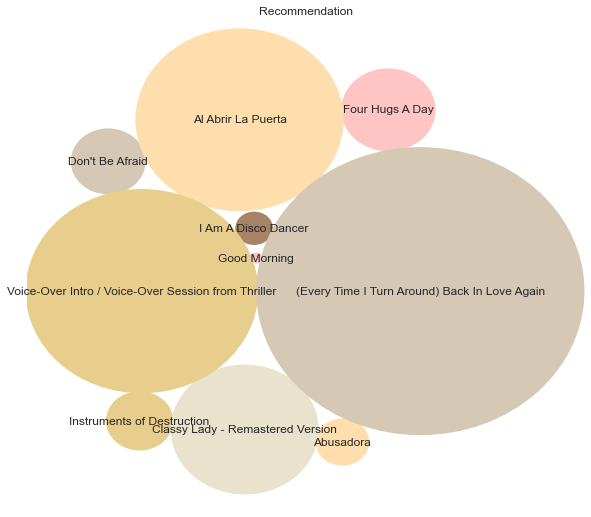

In [46]:
circlify_vizualization(results_with_artist_id['songs'])

## Circle graph to show recommended Artists

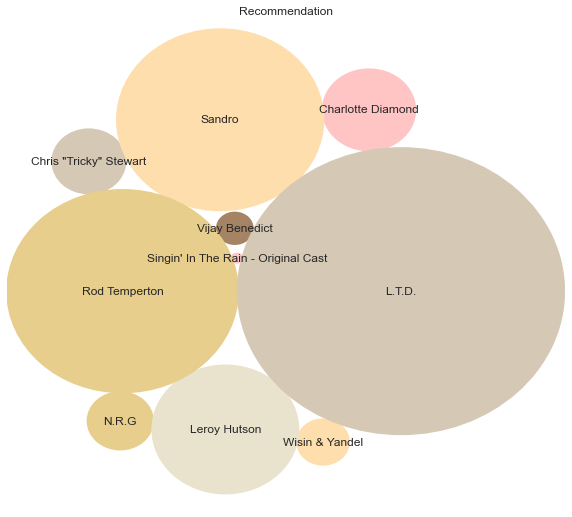

In [47]:
circlify_vizualization(results_with_artist_id['artist'])

## Circle graph to show recommended songs for new user

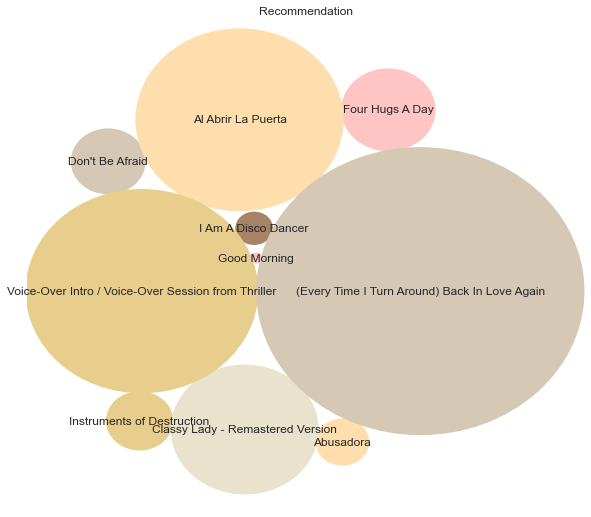

In [48]:
circlify_vizualization(results_for_new_user['songs'])

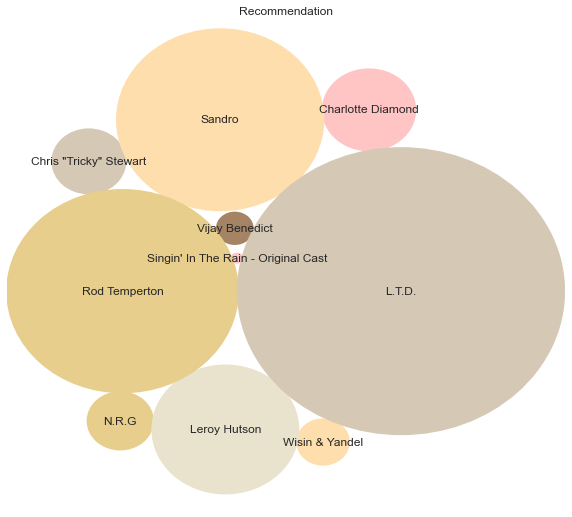

In [49]:
circlify_vizualization(results_for_new_user['artist'])